In [29]:
import torch, sys
print('Python:', sys.version)
print('Torch:', torch.__version__)
print('CUDA available:', torch.cuda.is_available())
print('Torch CUDA build:', getattr(torch.version, 'cuda', None))
if torch.cuda.is_available():
    print('GPU:', torch.cuda.get_device_name(0))
    print('CUDA device count:', torch.cuda.device_count())
else:
    print('NOTE: CUDA not available in this kernel.')

Python: 3.11.4 (tags/v3.11.4:d2340ef, Jun  7 2023, 05:45:37) [MSC v.1934 64 bit (AMD64)]
Torch: 2.4.1+cu121
CUDA available: True
Torch CUDA build: 12.1
GPU: NVIDIA GeForce RTX 3050 Laptop GPU
CUDA device count: 1


In [30]:
import os
import cv2
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import deque
from IPython.display import display, HTML, clear_output
import base64
from io import BytesIO
import time

from facenet_pytorch import MTCNN
from transformers import AutoImageProcessor, BeitForImageClassification

from pathlib import Path
model_path = str(Path(r"D:\Programs\CVDL\cvdl assign\final model 4").resolve())

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [31]:
# Debug: show the exact contents and whether path exists
print("model_path (repr):", repr(model_path))
import os
print("exists:", os.path.exists(model_path))
from pathlib import Path
try:
    print("resolved:", Path(model_path).resolve())
except Exception as e:
    print("Path resolve error:", e)

model_path (repr): 'D:\\Programs\\CVDL\\cvdl assign\\final model 4'
exists: True
resolved: D:\Programs\CVDL\cvdl assign\final model 4


In [32]:
model = BeitForImageClassification.from_pretrained(model_path).to(device)
processor = AutoImageProcessor.from_pretrained(model_path)
model.eval()

id2label = model.config.id2label
label2id = model.config.label2id
print(f"Loaded model with labels: {id2label}")

mtcnn = MTCNN(keep_all=True, device=device, post_process=False)
print("Face detector initialized")

Loaded model with labels: {0: 'bored', 1: 'confused', 2: 'engaged', 3: 'neutral'}
Face detector initialized


d:\Programs\CVDL\cvdl assign\.venv\Lib\site-packages\facenet_pytorch\models\mtcnn.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_dict_pat

In [33]:
def detect_and_crop_faces(image):
    """
    Detect faces in image and return cropped face regions with bounding boxes
    
    Args:
        image: PIL Image or numpy array
    
    Returns:
        faces: List of cropped face PIL Images
        boxes: List of bounding boxes [x1, y1, x2, y2]
        landmarks: List of facial landmarks
    """
    if isinstance(image, Image.Image):
        image_np = np.array(image)
    else:
        image_np = image
    
    boxes, probs, landmarks = mtcnn.detect(image_np, landmarks=True)
    
    if boxes is None:
        return [], [], []
    
    faces = []
    valid_boxes = []
    valid_landmarks = []
    
    for i, (box, landmark) in enumerate(zip(boxes, landmarks)):
        if probs[i] < 0.9:
            continue
            
        x1, y1, x2, y2 = [int(b) for b in box]
        margin = int((x2 - x1) * 0.2)
        
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(image_np.shape[1], x2 + margin)
        y2 = min(image_np.shape[0], y2 + margin)
        
        face_crop = image_np[y1:y2, x1:x2]
        faces.append(Image.fromarray(face_crop))
        valid_boxes.append([x1, y1, x2, y2])
        valid_landmarks.append(landmark)
    
    return faces, valid_boxes, valid_landmarks

def align_face(image, landmarks):
    """
    Align face using eye positions
    """
    if landmarks is None:
        return image
    
    left_eye = landmarks[0]
    right_eye = landmarks[1]
    
    dY = right_eye[1] - left_eye[1]
    dX = right_eye[0] - left_eye[0]
    angle = np.degrees(np.arctan2(dY, dX))
    
    image_np = np.array(image)
    center = tuple(np.array(image_np.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    aligned = cv2.warpAffine(image_np, rot_mat, image_np.shape[1::-1], flags=cv2.INTER_LINEAR)
    
    return Image.fromarray(aligned)

In [34]:
# Grad-CAM functionality has been removed from this project.
# This cell intentionally left minimal to preserve notebook structure.
print("Grad-CAM features have been removed.")

Grad-CAM features have been removed.


In [35]:
class TemporalSmoother:
    """Smooth predictions over time using exponential moving average"""
    
    def __init__(self, num_classes, window_size=10, alpha=0.3):
        self.num_classes = num_classes
        self.window_size = window_size
        self.alpha = alpha
        self.history = deque(maxlen=window_size)
        self.ema_probs = None
    
    def update(self, probs):
        """
        Update with new probabilities
        
        Args:
            probs: numpy array of class probabilities [num_classes]
        
        Returns:
            smoothed_probs: Smoothed probabilities
        """
        self.history.append(probs)
        
        if self.ema_probs is None:
            self.ema_probs = probs
        else:
            self.ema_probs = self.alpha * probs + (1 - self.alpha) * self.ema_probs
        
        return self.ema_probs
    
    def get_smoothed(self):
        """Get current smoothed probabilities"""
        return self.ema_probs if self.ema_probs is not None else np.zeros(self.num_classes)
    
    def reset(self):
        """Reset history"""
        self.history.clear()
        self.ema_probs = None

In [36]:
def predict_emotion(face_image, use_gradcam=False):
    """
    Predict emotion for a single face image

    Args:
        face_image: PIL Image of face
        use_gradcam: Ignored (Grad-CAM removed)

    Returns:
        prediction_dict: Dictionary with prediction results
    """
    inputs = processor(images=face_image, return_tensors="pt")
    pixel_values = inputs["pixel_values"].to(device)

    with torch.no_grad():
        outputs = model(pixel_values)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pred_class = torch.argmax(probs, dim=-1).item()

    probs_np = probs[0].cpu().numpy()
    pred_label = id2label[pred_class]
    confidence = probs_np[pred_class]

    result = {
        'label': pred_label,
        'confidence': confidence,
        'probabilities': {id2label[i]: float(probs_np[i]) for i in range(len(probs_np))},
        'class_id': pred_class
    }

    return result

In [37]:
def analyze_image_file(image_path):
    """
    Analyze a single image file: detection, alignment, prediction, and annotated output
    """
    image = Image.open(image_path).convert('RGB')

    print(f"Analyzing: {os.path.basename(image_path)}")
    print("=" * 60)

    faces, boxes, landmarks = detect_and_crop_faces(image)

    if len(faces) == 0:
        print("No faces detected in image")
        return

    print(f"Detected {len(faces)} face(s)\n")

    results = []
    for i, (face, box, landmark) in enumerate(zip(faces, boxes, landmarks)):
        print(f"Face {i+1}:")

        aligned_face = align_face(face, landmark)

        result = predict_emotion(aligned_face)
        results.append(result)

        print(f"  Prediction: {result['label']} ({result['confidence']:.2%})")
        print(f"\n  All Probabilities:")
        for emotion, prob in sorted(result['probabilities'].items(), key=lambda x: x[1], reverse=True):
            bar = "█" * int(prob * 30)
            print(f"    {emotion:12s}: {bar} {prob:.2%}")
        print()

    image_np = np.array(image)
    for i, (box, result) in enumerate(zip(boxes, results)):
        x1, y1, x2, y2 = box
        color = (0, 255, 0) if result['confidence'] > 0.7 else (255, 165, 0)
        cv2.rectangle(image_np, (x1, y1), (x2, y2), color, 3)

        label = f"{i+1}: {result['label']} {result['confidence']:.2%}"
        cv2.putText(image_np, label, (x1, y1 - 10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    plt.figure(figsize=(12, 10))
    plt.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Face Detection + Emotion Recognition Results", fontsize=14)
    plt.show()

    return results

In [38]:
print("\n" + "="*60)
print("ENHANCED EMOTION RECOGNITION SYSTEM READY!")
print("="*60)
print("\nAvailable Functions:\n")
print("1. analyze_image_file('path/to/image.jpg')")
print("   - Analyze image file: detection, alignment, prediction")
print("\n2. detect_and_crop_faces(image)")
print("   - Face detection only")
print("\n3. predict_emotion(face_image)")
print("   - Emotion prediction")
print("="*60)

print("\nExample Usage:")
print("# Analyze an image:")
print("analyze_image_file('/path/to/your/image.jpg')")


ENHANCED EMOTION RECOGNITION SYSTEM READY!

Available Functions:

1. analyze_image_file('path/to/image.jpg')
   - Analyze image file: detection, alignment, prediction

2. detect_and_crop_faces(image)
   - Face detection only

3. predict_emotion(face_image)
   - Emotion prediction

Example Usage:
# Analyze an image:
analyze_image_file('/path/to/your/image.jpg')


In [39]:
def live_demo_single_capture():
    """
    Single webcam capture with complete analysis:
    - Face detection & alignment
    - Emotion prediction with confidence
    - All emotion probabilities displayed
    """
    cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
    if not cap.isOpened():
        print("Could not access local webcam.")
        print("Ensure a webcam is connected and not used by another app")
        return

    print("Capturing image in 2 seconds...")
    print("Look at the camera and make an expression!")

    start_time = time.time()
    while time.time() - start_time < 2:
        ret, frame = cap.read()
        if not ret:
            break
        cv2.imshow('Webcam - Get Ready!', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    ret, frame = cap.read()
    cap.release()
    cv2.destroyAllWindows()

    if not ret:
        print("Failed to capture frame from webcam")
        return
        
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(frame_rgb)

    print("Image captured! Analyzing...\n")
    print("=" * 70)

    faces, boxes, landmarks = detect_and_crop_faces(image)

    if len(faces) == 0:
        print("No faces detected!")
        print("Try again with better lighting or camera position")
        plt.figure(figsize=(10, 6))
        plt.imshow(image)
        plt.title("Captured Image (No Face Detected)", fontsize=14)
        plt.axis('off')
        plt.show()
        return

    print(f"Detected {len(faces)} face(s)\n")

    for face_idx, (face, box, landmark) in enumerate(zip(faces, boxes, landmarks)):
        print(f"\n{'='*70}")
        print(f"FACE #{face_idx + 1} ANALYSIS")
        print(f"{'='*70}\n")
        
        if not isinstance(face, Image.Image):
            if isinstance(face, str):
                face = Image.open(face).convert('RGB')
            else:
                face = Image.fromarray(face.astype('uint8'))
                
        aligned_face = align_face(face, landmark)
        if not isinstance(aligned_face, Image.Image):
            aligned_face = Image.fromarray(aligned_face.astype('uint8'))
        aligned_face = aligned_face.convert('RGB')
        
        result = predict_emotion(aligned_face)
        
        print(f"EMOTION PREDICTION")
        print(f"   Primary Emotion: {result['label'].upper()}")
        print(f"   Confidence: {result['confidence']:.1%}")
        
        if result['confidence'] > 0.8:
            print(f"   Assessment: Very Confident")
        elif result['confidence'] > 0.6:
            print(f"   Assessment: Confident")
        else:
            print(f"   Assessment: Uncertain")
        
        print(f"\nALL EMOTION PROBABILITIES:")
        print(f"   {'-'*50}")
        
        sorted_emotions = sorted(
            result['probabilities'].items(), 
            key=lambda x: x[1], 
            reverse=True
        )
        
        for emotion, prob in sorted_emotions:
            bar_length = int(prob * 40)
            bar = "█" * bar_length
            bar_empty = "░" * (40 - bar_length)
            
            if emotion == result['label']:
                marker = ">"
            else:
                marker = " "
            
            print(f"   {marker} {emotion:12s} |{bar}{bar_empty}| {prob:6.2%}")
        
        print(f"   {'-'*50}\n")
        
        print("\n")

    print(f"{'='*70}")
    print("ANNOTATED RESULT")
    print(f"{'='*70}\n")

    if isinstance(image, Image.Image):
        image_np = np.array(image)
    else:
        image_np = image.copy()

    for i, (box, landmark) in enumerate(zip(boxes, landmarks)):
        x1, y1, x2, y2 = box
        
        face = faces[i]
        if not isinstance(face, Image.Image):
            face = Image.fromarray(face.astype('uint8'))
        aligned = align_face(face, landmark)
        result = predict_emotion(aligned)
        
        if result['confidence'] > 0.7:
            color = (0, 255, 0)
        elif result['confidence'] > 0.5:
            color = (255, 165, 0)
        else:
            color = (0, 0, 255)
        
        cv2.rectangle(image_np, (x1, y1), (x2, y2), color, 4)
        
        for point in landmark:
            cv2.circle(image_np, tuple(point.astype(int)), 4, (255, 0, 255), -1)
        
        label = f"#{i+1}: {result['label']} ({result['confidence']:.1%})"
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1.0
        thickness = 2
        (text_w, text_h), _ = cv2.getTextSize(label, font, font_scale, thickness)
        
        cv2.rectangle(image_np, (x1, y1 - text_h - 15), 
                     (x1 + text_w + 10, y1), color, -1)
        
        cv2.putText(image_np, label, (x1 + 5, y1 - 10),
                   font, font_scale, (255, 255, 255), thickness)

    plt.figure(figsize=(14, 10))
    plt.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Final Result: Face Detection + Emotion Recognition + Landmarks", fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

    print(f"\n{'='*70}")
    print("ANALYSIS COMPLETE!")
    print(f"{'='*70}\n")


Quick Start:
Running locally - using OpenCV webcam
Capturing image in 2 seconds...
Look at the camera and make an expression!
Capturing image in 2 seconds...
Look at the camera and make an expression!
Image captured! Analyzing...

Detected 1 face(s)


FACE #1 ANALYSIS

Image captured! Analyzing...

Detected 1 face(s)


FACE #1 ANALYSIS

EMOTION PREDICTION
   Primary Emotion: BORED
   Confidence: 85.6%
   Assessment: Very Confident

ALL EMOTION PROBABILITIES:
   --------------------------------------------------
   > bored        |██████████████████████████████████░░░░░░| 85.64%
     engaged      |████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░| 10.74%
     confused     |░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░|  2.20%
     neutral      |░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░|  1.42%
   --------------------------------------------------



ANNOTATED RESULT

EMOTION PREDICTION
   Primary Emotion: BORED
   Confidence: 85.6%
   Assessment: Very Confident

ALL EMOTION PROBABILITIES:
   --------

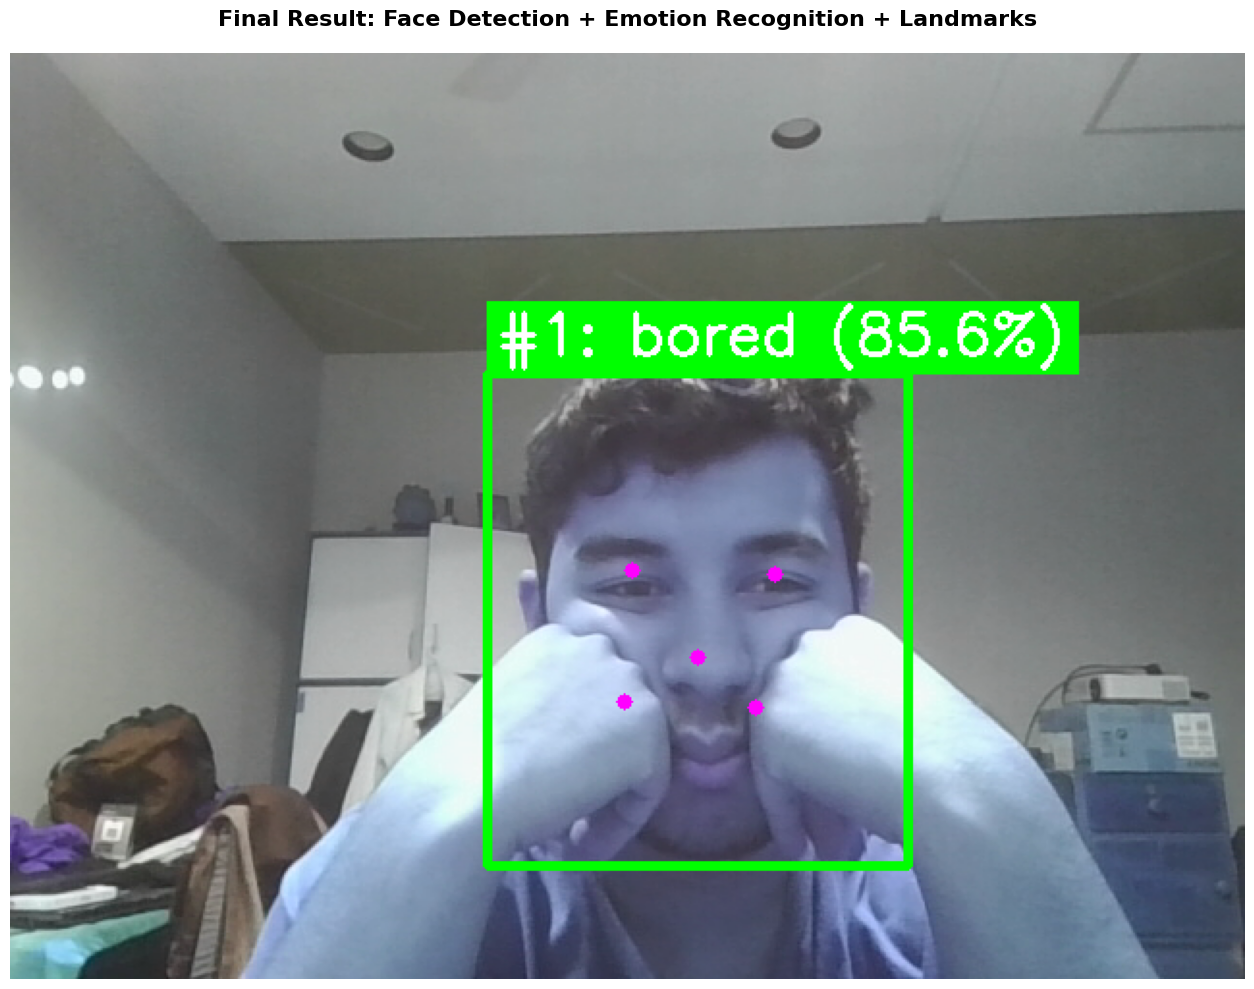


ANALYSIS COMPLETE!



In [ ]:
# print("\nQuick Start:")
# print("Running locally - using OpenCV webcam")
# live_demo_single_capture()

In [41]:
def real_time_emotion_detection():
    """
    Real-time emotion detection using webcam feed
    """
    import cv2
    import numpy as np
    from PIL import Image
    import time
    
    cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
    if not cap.isOpened():
        print("Could not access webcam")
        return
    
    cv2.namedWindow('Real-time Emotion Detection', cv2.WINDOW_NORMAL)
    
    smoother = TemporalSmoother(num_classes=len(id2label), window_size=10)
    
    print("Starting real-time emotion detection...")
    print("Press 'q' to quit")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture frame")
            break
            
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(frame_rgb)
        
        faces, boxes, _ = detect_and_crop_faces(pil_image)
        
        for face, box in zip(faces, boxes):
            if not isinstance(face, Image.Image):
                face = Image.fromarray(face.astype('uint8'))
            
            result = predict_emotion(face, use_gradcam=False)
            
            probs_array = np.array([result['probabilities'][id2label[j]] for j in range(len(id2label))])
            smoothed_probs = smoother.update(probs_array)
            smoothed_class = np.argmax(smoothed_probs)
            smoothed_label = id2label[smoothed_class]
            smoothed_confidence = smoothed_probs[smoothed_class]
            
            x1, y1, x2, y2 = box
            color = (0, 255, 0)
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            
            label = f"{smoothed_label.upper()}: {smoothed_confidence:.1%}"
            cv2.putText(frame, label, (x1, y1 - 10), 
                      cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
        
        cv2.imshow('Real-time Emotion Detection', frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()
    print("\nReal-time detection stopped")

In [ ]:
# print("Starting real-time emotion detection...")
# print("Please allow camera access when prompted")
# print("Press 'q' to quit the application\n")

# real_time_emotion_detection()

Starting real-time emotion detection...
Please allow camera access when prompted
Press 'q' to quit the application

Starting real-time emotion detection...
Press 'q' to quit
Starting real-time emotion detection...
Press 'q' to quit

Real-time detection stopped

Real-time detection stopped


In [43]:
import mss

print("Screen capture library installed and imported successfully!")
print("mss: Fast cross-platform screen capture")

Screen capture library installed and imported successfully!
mss: Fast cross-platform screen capture


In [44]:
def screen_emotion_detection(monitor=1, fps=5, region=None, use_temporal=True):
    """
    Real-time emotion detection from screen capture using mss library

    Args:
        monitor: Monitor number (1 = primary, 0 = all monitors)
        fps: Frames per second for capture (default: 5)
        region: Optional (x, y, width, height) to capture specific region
        use_temporal: Whether to use temporal smoothing

    Usage:
        screen_emotion_detection()
        screen_emotion_detection(region=(100, 100, 800, 600))
        screen_emotion_detection(fps=10)
    """
    print("Starting screen emotion detection...")
    print("Press 'q' to quit")
    print("="*70)

    if use_temporal:
        smoother = TemporalSmoother(num_classes=len(id2label), window_size=10)

    with mss.mss() as sct:
        if region:
            x, y, w, h = region
            monitor_dims = {"top": y, "left": x, "width": w, "height": h}
            print(f"Capturing region: {region}")
        else:
            monitor_dims = sct.monitors[monitor]
            print(f"Capturing monitor {monitor}: {monitor_dims}")
        
        frame_count = 0
        
        while True:
            screenshot = sct.grab(monitor_dims)
            
            img_np = np.array(screenshot)
            
            img_rgb = cv2.cvtColor(img_np, cv2.COLOR_BGRA2RGB)
            pil_image = Image.fromarray(img_rgb)
            
            faces, boxes, landmarks = detect_and_crop_faces(pil_image)
            
            frame_count += 1
            
            if len(faces) > 0:
                print(f"\nFrame {frame_count} - Found {len(faces)} face(s)")
                
                for i, (face, box, landmark) in enumerate(zip(faces, boxes, landmarks)):
                    if not isinstance(face, Image.Image):
                        face = Image.fromarray(face.astype('uint8'))
                    aligned_face = align_face(face, landmark)
                    
                    result = predict_emotion(aligned_face)
                    
                    if use_temporal:
                        probs_array = np.array([result['probabilities'][id2label[j]] 
                                               for j in range(len(id2label))])
                        smoothed_probs = smoother.update(probs_array)
                        smoothed_class = np.argmax(smoothed_probs)
                        smoothed_label = id2label[smoothed_class]
                        smoothed_confidence = smoothed_probs[smoothed_class]
                        
                        print(f"  Face {i+1}: {smoothed_label} ({smoothed_confidence:.1%})")
                        label_text = f"{smoothed_label}: {smoothed_confidence:.1%}"
                    else:
                        print(f"  Face {i+1}: {result['label']} ({result['confidence']:.1%})")
                        label_text = f"{result['label']}: {result['confidence']:.1%}"
                    
                    x1, y1, x2, y2 = box
                    color = (0, 255, 0) if result['confidence'] > 0.7 else (255, 165, 0)
                    cv2.rectangle(img_np, (x1, y1), (x2, y2), color, 2)
                    
                    cv2.putText(img_np, label_text, (x1, y1-10),
                              cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
            
            cv2.imshow('Screen Emotion Detection', img_np)
            
            if cv2.waitKey(int(1000/fps)) & 0xFF == ord('q'):
                break

    cv2.destroyAllWindows()
    print("\nScreen capture stopped")

In [45]:
def select_screen_region():
    """
    Interactive GUI to select screen region for capture
    
    Returns:
        tuple: (x, y, width, height) of selected region
    """
    import tkinter as tk
    
    root = tk.Tk()
    root.attributes('-alpha', 0.3)
    root.attributes('-topmost', True)
    root.configure(bg='blue')
    
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()
    root.geometry(f"{screen_width}x{screen_height}+0+0")
    
    canvas = tk.Canvas(root, cursor="cross", bg='blue')
    canvas.pack(fill=tk.BOTH, expand=True)
    
    rect = None
    start_x = start_y = 0
    selected_region = None
    
    def on_press(event):
        nonlocal start_x, start_y, rect
        start_x, start_y = event.x, event.y
        rect = canvas.create_rectangle(start_x, start_y, start_x, start_y,
                                      outline='red', width=3)
    
    def on_drag(event):
        canvas.coords(rect, start_x, start_y, event.x, event.y)
    
    def on_release(event):
        nonlocal selected_region
        end_x, end_y = event.x, event.y
        selected_region = (min(start_x, end_x), min(start_y, end_y),
                          abs(end_x - start_x), abs(end_y - start_y))
        root.quit()
        root.destroy()
    
    canvas.bind('<ButtonPress-1>', on_press)
    canvas.bind('<B1-Motion>', on_drag)
    canvas.bind('<ButtonRelease-1>', on_release)
    
    print("Drag to select screen region, then release")
    root.mainloop()
    
    return selected_region

In [ ]:
# print("SCREEN EMOTION DETECTION DEMO")
# print("="*70)
# print("\nInstructions:")
# print("1. Open a video/image with faces on your screen")
# print("2. Uncomment ONE of the options below")
# print("3. Run this cell to start analysis")
# print("4. Press 'q' in the display window to stop")
# print("\n" + "="*70)

# # OPTION 1: Full screen capture
# screen_emotion_detection()

# # OPTION 2: Select region first (recommended for video players)
# # region = select_screen_region()
# # if region:
# #     print(f"\nSelected region: {region}")
# #     screen_emotion_detection(region=region, fps=5, use_temporal=True)

# # OPTION 3: Higher FPS
# # screen_emotion_detection(fps=10, use_temporal=True)

# print("\nUncomment one option above to start!")

SCREEN EMOTION DETECTION DEMO

Instructions:
1. Open a video/image with faces on your screen
2. Uncomment ONE of the options below
3. Run this cell to start analysis
4. Press 'q' in the display window to stop

Starting screen emotion detection...
Press 'q' to quit
Capturing monitor 1: {'left': 0, 'top': 0, 'width': 1920, 'height': 1080}

Frame 1 - Found 1 face(s)

Frame 1 - Found 1 face(s)
  Face 1: bored (40.3%)
  Face 1: bored (40.3%)

Screen capture stopped

Uncomment one option above to start!

Screen capture stopped

Uncomment one option above to start!



Usage guidelines:
 - For options 1 and 2, ensure your webcam is connected and not in use by another app.
 - For option 3 (screen), make sure the screen content you want to analyze is visible and that the "mss" package is installed.
 - During real-time captures, press 'q' in the display window to stop the capture.
 - Uncomment ONE of the options below
 - Run this cell to start analysis
Capturing image in 2 seconds...
Look at the camera and make an expression!
Capturing image in 2 seconds...
Look at the camera and make an expression!
Image captured! Analyzing...

Detected 1 face(s)


FACE #1 ANALYSIS

Image captured! Analyzing...

Detected 1 face(s)


FACE #1 ANALYSIS

EMOTION PREDICTION
   Primary Emotion: CONFUSED
   Confidence: 39.1%
   Assessment: Uncertain

ALL EMOTION PROBABILITIES:
   --------------------------------------------------
   > confused     |███████████████░░░░░░░░░░░░░░░░░░░░░░░░░| 39.11%
     engaged      |█████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░| 32.63%
     neutra

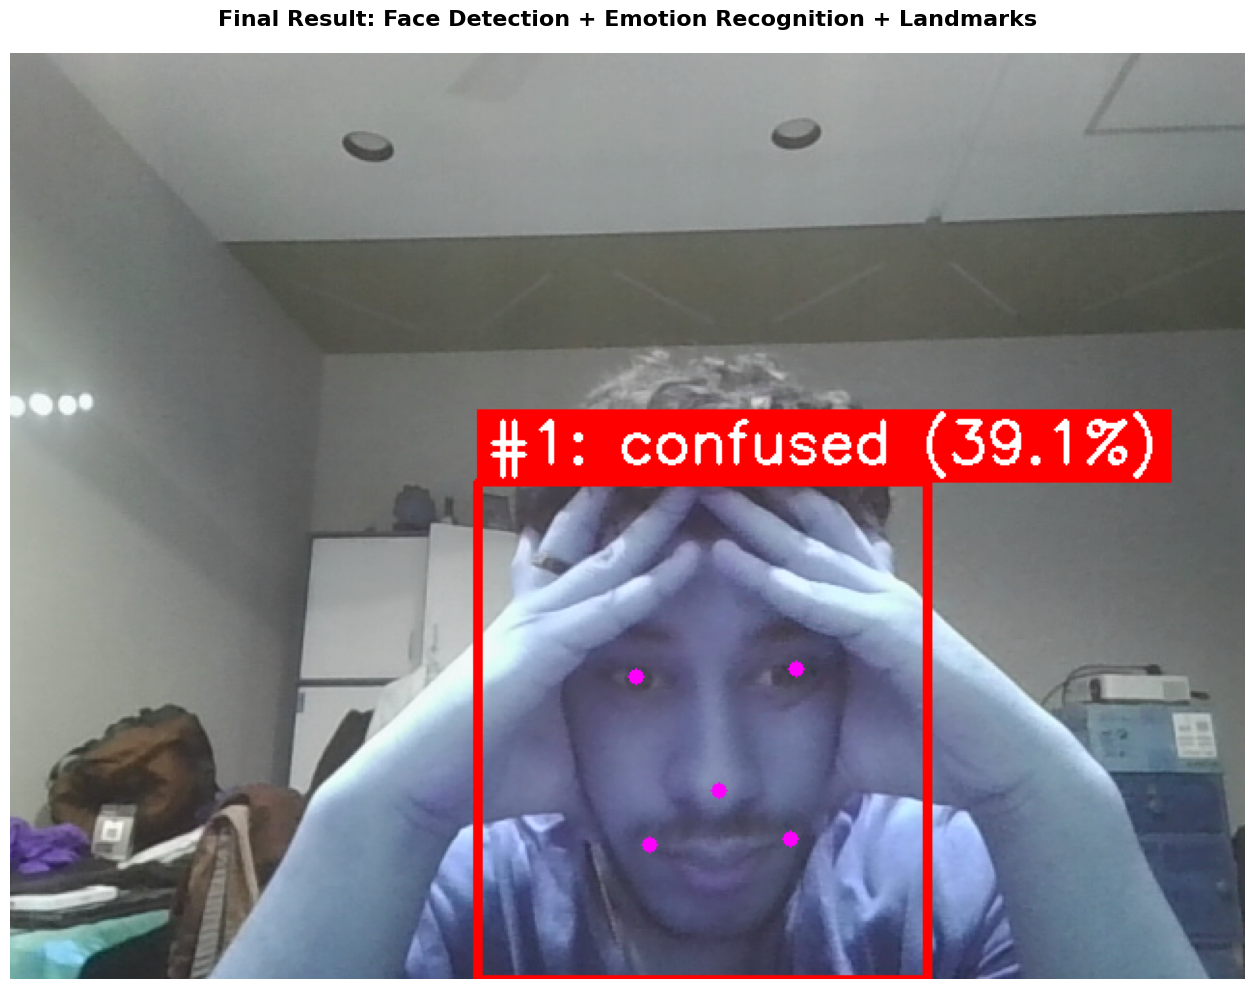


ANALYSIS COMPLETE!



In [ ]:
print('\nUsage guidelines:')
print(' - For options 1 and 2, ensure your webcam is connected and not in use by another app.')
print(' - For option 3 (screen), make sure the screen content you want to analyze is visible and that the "mss" package is installed.')
print(" - During real-time captures, press 'q' in the display window to stop the capture.")
print(" - Uncomment ONE of the options below")
print(" - Run this cell to start analysis")

##Option - 1: Single Capture
live_demo_single_capture()

##Option - 2: Live Webcam testing
#real_time_emotion_detection()

##Option - 3: Screen Testing
#screen_emotion_detection()